In [4]:
# Import packages and connect to database
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

In [ ]:
### Data Cleaning

In [5]:
with open('More_Than_1Acre.pickle','rb') as read_file:
    fires = pickle.load(read_file)

In [79]:
#fires.to_csv('firedata.csv')

In [6]:
fires['FIRE_SIZE_CLASS'].value_counts()

B    472539
C    220077
D     28427
E     14107
F      7786
G      3773
Name: FIRE_SIZE_CLASS, dtype: int64

In [153]:
fires['FIRE_SIZE_CLASS_BIN'] = np.where(fires['FIRE_SIZE']> 20, 0, 1)
fires['FIRE_SIZE_CLASS_BIN'].value_counts()

1    27982
0    27823
Name: FIRE_SIZE_CLASS_BIN, dtype: int64

In [115]:
fires['FIRE_YEAR'].value_counts()

2012    5027
2011    4806
2006    4026
2014    3995
2015    3869
2007    3766
2000    3612
2009    3472
2013    3458
2008    3170
2010    3134
2005    3051
2001    2928
2002    2747
2003    2717
2004    2027
Name: FIRE_YEAR, dtype: int64

In [116]:
# NOAA climate regions
fires['REGION'] = np.where(fires['STATE'].isin(['WA', 'OR', 'ID']), 'Northwest', 
                  np.where(fires['STATE'].isin(['CA', 'NV']), 'West', 
                  np.where(fires['STATE'].isin(['MT', 'NE', 'ND', 'SD', 'WY']), 'Northern Rockies', 
                  np.where(fires['STATE'].isin(['AK']), 'Alaska', 
                  np.where(fires['STATE'].isin(['AZ', 'NM', 'CO', 'UT']), 'Southwest',          
                  np.where(fires['STATE'].isin(['OK', 'TX', 'KS', 'AR', 'LA', 'MS']), 'South', 
                  np.where(fires['STATE'].isin(['AL', 'FL', 'GA', 'NC', 'SC', 'VA']), 'Southeast', 
                  np.where(fires['STATE'].isin(['IL', 'IN', 'KY', 'MO', 'TN', 'OH', 'WV']), 'Ohio Valley', 
                  np.where(fires['STATE'].isin(['IA',  'MI', 'MN', 'WI']), 'Upper Midwest', 
                  np.where(fires['STATE'].isin(['CT', 'NY', 'ME', 'MA', 'MD', 'NH', 'NJ', 'PA', 'RI', 'VT', 'DE']), 'Northeast', 'Other'        
                                  ))))))))))

In [117]:
fires['REGION'].value_counts()

Southwest           11175
Northwest            9971
South                6874
West                 6144
Northern Rockies     5864
Southeast            5820
Ohio Valley          5385
Alaska               2282
Northeast            1552
Upper Midwest         623
Other                 115
Name: REGION, dtype: int64

In [118]:
# Creating new date variables
fires['DAYS_TO_CONTAIN'] = fires['CONT_DATE'] - fires['DISCOVERY_DATE'] 
fires['DAYS_TO_CONTAIN'] = fires['DAYS_TO_CONTAIN'].fillna(0)
fires['DISCOVERY_DATE_DT'] = pd.to_datetime(fires['DISCOVERY_DATE'], unit='D', origin='julian')
fires['CONT_DATE_DT'] = pd.to_datetime(fires['CONT_DATE'], unit='D', origin='julian')

In [82]:
fires = fires[fires['DAYS_TO_CONTAIN']>0]
fires = fires[fires['FIRE_YEAR'] >= 2000]

In [50]:
fires.corr()

,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DATE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,FIRE_SIZE_CLASS_BIN,DAYS_TO_CONTAIN
OBJECTID,1.000000,0.816668,0.695487,0.693496,-0.120424,0.216974,0.693138,-0.108675,-0.009525,-0.071689,0.244119,0.302885,0.016338,0.024365
FOD_ID,0.816668,1.000000,0.722242,0.720993,-0.096026,0.086556,0.720953,-0.069611,0.003100,-0.030505,0.111433,0.120654,-0.003821,0.056310
FIRE_YEAR,0.695487,0.722242,1.000000,0.999603,-0.086250,0.060423,0.999543,-0.054481,0.017624,-0.031918,0.087215,0.069805,0.018157,0.077654
DISCOVERY_DATE,0.693496,0.720993,0.999603,1.000000,-0.058129,0.055266,0.999943,-0.027562,0.017858,-0.027611,0.081077,0.065782,0.018217,0.077930
DISCOVERY_DOY,-0.120424,-0.096026,-0.086250,-0.058129,1.000000,-0.186640,-0.058032,0.955203,0.007048,0.154515,-0.223175,-0.147207,0.000875,0.004120
STAT_CAUSE_CODE,0.216974,0.086556,0.060423,0.055266,-0.186640,1.000000,0.054283,-0.216921,-0.052785,-0.217768,0.310476,0.368962,0.020012,-0.086878
CONT_DATE,0.693138,0.720953,0.999543,0.999943,-0.058032,0.054283,1.000000,-0.025545,0.019634,-0.025704,0.079739,0.065645,0.019236,0.088599
CONT_DOY,-0.108675,-0.069611,-0.054481,-0.027562,0.955203,-0.216921,-0.025545,1.000000,0.067751,0.217074,-0.261910,-0.147186,0.034837,0.185516
FIRE_SIZE,-0.009525,0.003100,0.017624,0.017858,0.007048,-0.052785,0.019634,0.067751,1.000000,0.113130,-0.115288,-0.037209,0.121081,0.166892
LATITUDE,-0.071689,-0.030505,-0.031918,-0.027611,0.154515,-0.217768,-0.025704,0.217074,0.113130,1.000000,-0.668059,-0.145915,0.006548,0.175292


In [31]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77146 entries, 16 to 1880458
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   OBJECTID                    77146 non-null  int64         
 1   FOD_ID                      77146 non-null  int64         
 2   FPA_ID                      77146 non-null  object        
 3   SOURCE_SYSTEM_TYPE          77146 non-null  object        
 4   SOURCE_SYSTEM               77146 non-null  object        
 5   NWCG_REPORTING_AGENCY       77146 non-null  object        
 6   NWCG_REPORTING_UNIT_ID      77146 non-null  object        
 7   NWCG_REPORTING_UNIT_NAME    77146 non-null  object        
 8   SOURCE_REPORTING_UNIT       77146 non-null  object        
 9   SOURCE_REPORTING_UNIT_NAME  77146 non-null  object        
 10  LOCAL_FIRE_REPORT_ID        38281 non-null  object        
 11  FIRE_NAME                   68464 non-null  object 

In [175]:
fires['SOURCE_REPORTING_UNIT'].value_counts()

KYKYS     1846
AKAFS     1779
FLFLS     1418
WVDOF      899
WADNR      863
          ... 
WYSHX        1
NY5361       1
NMWHI        1
COARR        1
NY3064       1
Name: SOURCE_REPORTING_UNIT, Length: 1512, dtype: int64

In [ ]:
#Source_System_type

In [154]:
from sklearn.model_selection import train_test_split

fires_train, fires_test = train_test_split(fires, test_size=0.2, random_state=42)

In [155]:
data_crosstab = pd.crosstab(fires_train['STAT_CAUSE_DESCR'], 
                            fires_train['FIRE_SIZE_CLASS_BIN'],  
                               margins = False, normalize = 'index') 
print(data_crosstab) 

FIRE_SIZE_CLASS_BIN         0         1
STAT_CAUSE_DESCR                       
Arson                0.491026  0.508974
Campfire             0.396481  0.603519
Children             0.290141  0.709859
Debris Burning       0.494552  0.505448
Equipment Use        0.585302  0.414698
Fireworks            0.459596  0.540404
Lightning            0.497518  0.502482
Miscellaneous        0.484354  0.515646
Missing/Undefined    0.665667  0.334333
Powerline            0.606762  0.393238
Railroad             0.509294  0.490706
Smoking              0.327500  0.672500
Structure            0.301205  0.698795


In [ ]:
# Box and whisker plot of fire size by cause 

In [156]:
data_crosstab = pd.crosstab(fires_train['REGION'], 
                            fires_train['FIRE_SIZE_CLASS_BIN'],  
                               margins = False, normalize = 'index') 
print(data_crosstab) 

FIRE_SIZE_CLASS_BIN         0         1
REGION                                 
Alaska               0.663943  0.336057
Northeast            0.115669  0.884331
Northern Rockies     0.469361  0.530639
Northwest            0.478603  0.521397
Ohio Valley          0.594872  0.405128
Other                0.684783  0.315217
South                0.625362  0.374638
Southeast            0.469030  0.530970
Southwest            0.418925  0.581075
Upper Midwest        0.397177  0.602823
West                 0.553721  0.446279


In [ ]:
# Box and whisker plot of fire size by region

In [14]:
#plt.scatter(data=fires_train, x='DAYS_TO_CONTAIN', y='FIRE_SIZE', marker='o', s=25);


In [157]:
combined_df = pd.get_dummies(fires_train, columns = ['STAT_CAUSE_DESCR', 'REGION'], drop_first = True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44644 entries, 1316643 to 306547
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   OBJECTID                            44644 non-null  int64         
 1   FOD_ID                              44644 non-null  int64         
 2   FPA_ID                              44644 non-null  object        
 3   SOURCE_SYSTEM_TYPE                  44644 non-null  object        
 4   SOURCE_SYSTEM                       44644 non-null  object        
 5   NWCG_REPORTING_AGENCY               44644 non-null  object        
 6   NWCG_REPORTING_UNIT_ID              44644 non-null  object        
 7   NWCG_REPORTING_UNIT_NAME            44644 non-null  object        
 8   SOURCE_REPORTING_UNIT               44644 non-null  object        
 9   SOURCE_REPORTING_UNIT_NAME          44644 non-null  object        
 10  LOCAL_FIRE_REPO

### Logistic Regression

In [123]:
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_df[['STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])
y_train = combined_df['FIRE_SIZE_CLASS_BIN']

In [124]:
lm_3 = LogisticRegressionCV()
lm_3.fit(X_train, y_train)
lm_3.score(X_train, y_train)

0.5950855658095153

In [158]:
combined_df_test = pd.get_dummies(fires_test, columns = ['STAT_CAUSE_DESCR', 'REGION'], drop_first = True)
combined_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11161 entries, 144545 to 1360587
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   OBJECTID                            11161 non-null  int64         
 1   FOD_ID                              11161 non-null  int64         
 2   FPA_ID                              11161 non-null  object        
 3   SOURCE_SYSTEM_TYPE                  11161 non-null  object        
 4   SOURCE_SYSTEM                       11161 non-null  object        
 5   NWCG_REPORTING_AGENCY               11161 non-null  object        
 6   NWCG_REPORTING_UNIT_ID              11161 non-null  object        
 7   NWCG_REPORTING_UNIT_NAME            11161 non-null  object        
 8   SOURCE_REPORTING_UNIT               11161 non-null  object        
 9   SOURCE_REPORTING_UNIT_NAME          11161 non-null  object        
 10  LOCAL_FIRE_REPO

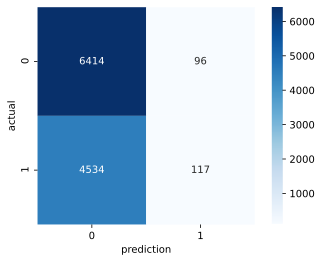

In [126]:
X_test = scaler.transform(combined_df_test[['STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])


preds = lm_3.predict(X_test)

conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

In [127]:
lm_3.score(X_test, combined_df_test['FIRE_SIZE_CLASS_BIN'])

0.5851626198369322

In [128]:
f1_score(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)

0.04810855263157895

In [129]:
combined_df_test['FIRE_SIZE_CLASS_BIN'].value_counts()

0    6510
1    4651
Name: FIRE_SIZE_CLASS_BIN, dtype: int64

In [130]:
combined_df_test['proba_lrg'] = lm_3.predict_proba(combined_df_test[['STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure']])[:, 1]

fpr, tpr, thresholds = roc_curve(combined_df_test['FIRE_SIZE_CLASS_BIN'],
                                 combined_df_test['proba_lrg'])

def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

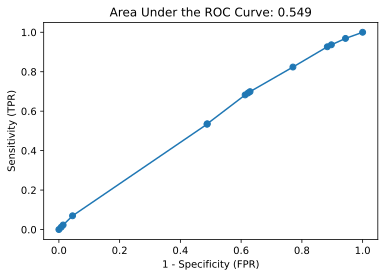

In [131]:
plot_roc(combined_df_test['FIRE_SIZE_CLASS_BIN'], lm_3.predict_proba(X_test)[:, 1])

In [132]:
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_df[['REGION_Other', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West']])
y_train = combined_df['FIRE_SIZE_CLASS_BIN']

    

In [133]:
lm_4 = LogisticRegressionCV()
lm_4.fit(X_train, y_train)
lm_4.score(X_train, y_train)

0.6090404085655408

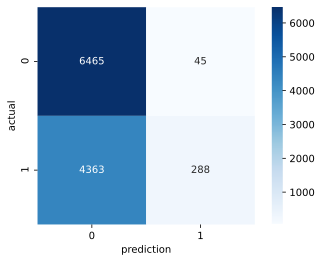

In [134]:
X_test = scaler.transform(combined_df_test[[ 'REGION_Other', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West']])


preds = lm_4.predict(X_test)

conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

In [168]:
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_df[['REGION_Other', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure', 'DISCOVERY_DATE',
                      'LATITUDE', 'LONGITUDE']])
y_train = combined_df['FIRE_SIZE_CLASS_BIN']

In [169]:
lm_5 = LogisticRegressionCV()
lm_5.fit(X_train, y_train)
lm_5.score(X_train, y_train)

0.589440910312696

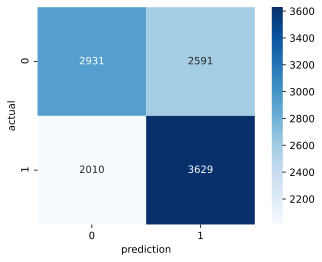

In [170]:
X_test = scaler.transform(combined_df_test[[ 'REGION_Other', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure', 'DISCOVERY_DATE',
                      'LATITUDE', 'LONGITUDE']])


preds = lm_5.predict(X_test)

conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

### KNN

In [166]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X_train = combined_df[['REGION_Other', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure', 'DISCOVERY_DATE',
                      'LATITUDE', 'LONGITUDE']]

y_train = combined_df['FIRE_SIZE_CLASS_BIN']


knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[0.59395297 0.59596865 0.5849944  0.60940649 0.60573477 0.60663082
 0.59296595 0.59341398 0.59968638 0.59274194]


In [167]:
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[0.59664054 0.59664054 0.58701008 0.59148936 0.60058244 0.60663082
 0.59341398 0.58781362 0.59094982 0.59699821]


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
# either Bernoulli or Multinomial
nb = NB()
nb.fit(X_train, y_train)
nb.score(X_train, y_train)

### Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [176]:
X_train = combined_df[['REGION_Other', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure', 'DISCOVERY_DATE',
                      'LATITUDE', 'LONGITUDE']]

y_train = combined_df['FIRE_SIZE_CLASS_BIN']


In [177]:
randomforest = RandomForestClassifier(n_estimators=1000)
quick_test_afew_times(randomforest, X_train, y_train)

0.6441914289980588

In [161]:
X_test = (combined_df_test[[ 'REGION_Other', 
                    'REGION_Northeast', 'REGION_Northern Rockies',
                     'REGION_Northwest', 'REGION_Ohio Valley',
                     'REGION_South', 'REGION_Southeast', 
                     'REGION_Southwest', 'REGION_Upper Midwest',             
                     'REGION_West', 'STAT_CAUSE_DESCR_Campfire', 
                    'STAT_CAUSE_DESCR_Children', 'STAT_CAUSE_DESCR_Debris Burning',
                     'STAT_CAUSE_DESCR_Equipment Use', 'STAT_CAUSE_DESCR_Fireworks',
                     'STAT_CAUSE_DESCR_Lightning', 'STAT_CAUSE_DESCR_Miscellaneous', 
                     'STAT_CAUSE_DESCR_Missing/Undefined', 'STAT_CAUSE_DESCR_Powerline',             
                     'STAT_CAUSE_DESCR_Railroad', 'STAT_CAUSE_DESCR_Smoking',
                      'STAT_CAUSE_DESCR_Structure', 'DISCOVERY_DATE',
                      'LATITUDE', 'LONGITUDE']])


preds = randomforest.predict(X_test)

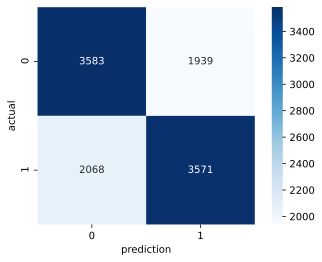

In [162]:
conf_matrix = confusion_matrix(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('actual');

In [163]:
f1_score(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)

0.6405955691093372

In [164]:
recall_score(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)

0.6332683099840397

In [165]:
precision_score(combined_df_test['FIRE_SIZE_CLASS_BIN'], preds)

0.6480943738656987

In [55]:
def visualize(X, y, bdry='diag'):
    c = cm.rainbow(np.linspace(0, 1, 2))
    plt.scatter([i[0] for i in X], [i[1] for i in X], color=[c[i] for i in y], alpha=.5)
    
    #Plot the true decision boundary
    if bdry == 'diag':
        plt.plot([0, 1], [0, 1], 'k--')
    elif bdry == 'quadrant':
        plt.plot([0, 1], [0.5, 0.5], 'k--')
        plt.plot([0.5, 0.5], [0, 1], 'k--')
        
    plt.grid(True)
    

In [56]:
randomforest.fit(X_train, y_train)

grid = np.mgrid[0:1.02:0.02, 0:1.02:0.02].reshape(2,-1).T
visualize(grid, randomforest.predict(grid))

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 2 

In [ ]:
# Need to do
# Precision Recall Curve
# Correlation 